This is an implementation of the famous ResNet Paper [He et al., 2015. Deep residual networks for image recognition].
In particular, I will try to prove the below points

* Train a 20-layer, a 32 layer, a 56 layer and a 110 layer plain network as well as the corresponding residual networks on
  the  famous cifar-10 dataset and plot their validation and train error for multiple epochs
* Verify that the training loss (and not only the validation loss)  increases as the network becomes deeper for plain
  networks and hence overfitting is not the cause of this accuracy degradation
* Prove that contrary to the plain nets the training and validation errors decreases for ResNets with an increase in the
  depth of the network
* Compare the validation data accuracy of different models ( resnet-20, resnet-32, resnet-56, plain net-20, plain net 32,
  VGG-16)  and prove that using the residual blocks not only increases the accuracy, but it also reduces the model
  complexity and computation
* Run one resnet model for a very high epoch(~150) to get higher accuracy  
* Verify that the overfitting kicks in residual networks as well if it is too deep (over 1000-layers)   






Let us import the relevant packages first

In [1]:
import pandas as pd
import keras
from keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
from keras.datasets import cifar10

from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, ZeroPadding2D, Input,BatchNormalization
import numpy as np
import math
from keras import backend, layers
from keras.models import Model
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.applications.vgg16 import VGG16

import os
import sys
import random

Using TensorFlow backend.


If you want to import a python file, from your local to the jupyter notebook, you need to run the below commands

In [2]:
sys.path.insert(len(sys.path),os.getcwd())
import RelevantModelCIFAR as models
import AdHocCIFAR as utility

Now let us define important parameters

In [4]:
batch_size=64
num_classes=10
epochs=150
save_dir = os.path.join(os.getcwd(), 'saved_model')

Now let us load the cifar10 dataset. Keras has this dataset, so we just need to load it.

In [5]:
(train_images, train_labels), (val_images, val_Labels) = cifar10.load_data()
print(len(train_images))
print(len(train_labels))

50000
50000


It is always better to randomize the dataset. Below chunk will randomize the 

In [6]:
def randomize(images, labels):
    perm = list(range(len(images)))
    random.shuffle(perm)
    images = [images[index] for index in perm]
    labels = [labels[index] for index in perm]
    return images, labels    

In [7]:
train_images, train_labels = randomize(train_images, train_labels)
val_images, val_Labels = randomize(val_images, val_Labels)

We need to train our models on batches of data. After exploring various options, I feel that using a data generator will be very handy as it helps in avoiding OOM(Out Of Memory) issues. So I have created the below function which will do preprocessing of these images, and it will be passed to the ImageDataGenerator() instance.

In [8]:
def get_data(data, labels):
    indexx = 0
    size = len(data)
    current_index = 0
    if(current_index + batch_size >= len(data)):
                current_index = 0
    B = np.zeros(shape=(size, 32, 32, 3))
    L = np.zeros(shape=(size))

    while indexx < size:
        try:
            B[indexx] = img_to_array(data[current_index])                 
            B[indexx] /=255
            
            L[indexx] = labels[current_index]

            indexx = indexx + 1
            current_index = current_index + 1
            if(current_index + batch_size >= len(data)):
                current_index = 0
        except:
            print("Ignore image {}".format(data[current_index]))
            current_index = current_index + 1

    return B, keras.utils.to_categorical(L, num_classes)

In [9]:
datagen = ImageDataGenerator()

I have implemented the important models in the RelevantModelCIFAR.py file and imported here as models. It contains the plaiNetwork models and Residual Network model.so as Shown below, when I am calling it as models.plainNets(44), I will get a 44 layer plain nets. Siilarly, models.ResNets(44) will return a 440layer residual network. Since we need to fit a  lot of models of different layers, we just need to change the number of layers parameter and keep running the below codes

In [10]:
#model = models.PlainNets(110)
model = models.ResNets(depth=44, input_shape=(32,32,3))
#model = VGG16(weights=None, include_top=True, classes=10, input_shape=(32,32,3))

shape of x after maxpool : (?, 32, 32, 16)
This
shape of X_shortcut : (?, 32, 32, 16)
shape of x : (?, 32, 32, 16)
calling 2nd conv block : (?, 32, 32, 16)
This
shape of X_shortcut : (?, 16, 16, 32)
shape of x : (?, 16, 16, 32)
calling 3rd conv block :
This
shape of X_shortcut : (?, 8, 8, 64)
shape of x : (?, 8, 8, 64)
called 3rd conv block :


As specified in the paper as well, we will be using SGD optimizer with learning rate=0,001 and momentum=0.9. One can feel free to try out other optimizers, or try out SGD with different parameters. The loss used is categorical_crossentropy.
model.summary() is a nice way to review the architecture of your model.

In [11]:
opt = SGD(lr=0.0001, momentum=0.9)

model.compile(loss='categorical_crossentropy',
             optimizer=opt,
             metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 34, 34, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 16)   448         pool1_pad[0][0]                  
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv1[0][0]                      
__________________________________________________________________________________________________
activation

The right approach to use the datagenerator in the model is to use the fit_generator() method. Out of various parameters, we need to specify the number if train steps and validation steps. Below two lines will calculate these. It will cover the whole dataset.

In [12]:
train_steps = math.floor(len(train_images)/(batch_size))
val_steps = math.floor(len(val_images)/(batch_size))

Now it's time to fit our model.

In [ ]:
history = model.fit_generator(datagen.flow(get_data(train_images, train_labels), batch_size=batch_size), 
                              steps_per_epoch=train_steps, 
                              epochs=epochs, 
                              verbose=1, 
                              validation_data=datagen.flow(get_data(val_images, val_Labels), batch_size=batch_size), 
                              validation_steps=val_steps, 
                              use_multiprocessing=True, 
                              initial_epoch=0)

Epoch 1/150
781/781 [==============================] - 38s 49ms/step - loss: 2.1320 - acc: 0.2064 - val_loss: 1.9058 - val_acc: 0.2714
Epoch 2/150
781/781 [==============================] - 32s 41ms/step - loss: 1.8427 - acc: 0.2988 - val_loss: 1.7946 - val_acc: 0.3192
Epoch 3/150
781/781 [==============================] - 32s 41ms/step - loss: 1.7629 - acc: 0.3369 - val_loss: 1.7378 - val_acc: 0.3454
Epoch 4/150
781/781 [==============================] - 33s 42ms/step - loss: 1.7063 - acc: 0.3613 - val_loss: 1.6758 - val_acc: 0.3705
Epoch 5/150
781/781 [==============================] - 33s 42ms/step - loss: 1.6625 - acc: 0.3769 - val_loss: 1.6395 - val_acc: 0.3835
Epoch 6/150
781/781 [==============================] - 33s 42ms/step - loss: 1.6225 - acc: 0.3946 - val_loss: 1.6096 - val_acc: 0.4002
Epoch 7/150
781/781 [==============================] - 33s 42ms/step - loss: 1.5914 - acc: 0.4081 - val_loss: 1.5734 - val_acc: 0.4119
Epoch 8/150
781/781 [==============================] - 

781/781 [==============================] - 33s 43ms/step - loss: 0.8706 - acc: 0.6922 - val_loss: 1.2665 - val_acc: 0.5631
Epoch 62/150
781/781 [==============================] - 33s 43ms/step - loss: 0.8593 - acc: 0.6968 - val_loss: 1.3033 - val_acc: 0.5494
Epoch 63/150
781/781 [==============================] - 33s 42ms/step - loss: 0.8498 - acc: 0.6994 - val_loss: 1.2781 - val_acc: 0.5530
Epoch 64/150
781/781 [==============================] - 33s 42ms/step - loss: 0.8426 - acc: 0.7017 - val_loss: 1.2930 - val_acc: 0.5536
Epoch 65/150
781/781 [==============================] - 33s 42ms/step - loss: 0.8313 - acc: 0.7064 - val_loss: 1.2775 - val_acc: 0.5612
Epoch 66/150
781/781 [==============================] - 33s 43ms/step - loss: 0.8215 - acc: 0.7112 - val_loss: 1.2879 - val_acc: 0.5620
Epoch 67/150
781/781 [==============================] - 33s 42ms/step - loss: 0.8139 - acc: 0.7121 - val_loss: 1.2665 - val_acc: 0.5668
Epoch 68/150
781/781 [==============================] - 32s 4

model.fit_generator() will create a History instance whcih will contain all the relevant information about the model. I have created an utility function which will give me a pandas dataframe, with all the relevant tables, where I would want to save  the loss and accuracy of different models

In [234]:
path = r'/home/xena/Desktop/manoranjan/model_losses_imagenet.csv'
df_model_hist = getResultDataFrame(path)

In [5]:
#df_losses = pd.read_csv(r'/home/xena/Desktop/manoranjan/model_losses_imagenet.csv')

Now let us load the results of our model to the dataframe we have created.  Note that below chunck is just an example,and it will store the result of the current model only(resNet44 in this case). What I have done is, iterate for all the relevant models and saved it in this dataframe, by manually changing column names.  

In [235]:
history_dict = history.history
df_model_hist['train_loss_resnet44'] = history_dict['loss']
df_model_hist['val_loss_resnet44'] = history_dict['val_loss']
df_model_hist['train_acc_resnet44'] = history_dict['acc']
df_model_hist['val_acc_resnet44'] = history_dict['val_acc']

TypeError: 'NoneType' object does not support item assignment

In [170]:
df_model_hist.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,epochs,train_loss_resnet20,val_loss_resnet20,train_acc_resnet20,val_acc_resnet20,...,train_acc_resnet50,val_acc_resnet50,train_loss_resnet38,val_loss_resne38,train_acc_resnet38,val_acc_resnet38,train_loss_VGG16,val_loss_VGG16,train_acc_VGG16,val_acc_VGG16
0,0,0,0,0,0,0,2.240192,2.049467,0.186739,0.242989,...,0.204642,0.253405,2.323131,2.079327,0.179550,0.221955,2.302520,2.302427,0.108299,0.157151
1,1,1,1,1,1,1,1.963892,1.880281,0.276113,0.317834,...,0.279057,0.305052,1.982566,1.907348,0.257850,0.289151,2.302385,2.302310,0.137536,0.152476
2,2,2,2,2,2,2,1.842666,1.784500,0.322533,0.344907,...,0.317566,0.331019,1.854706,1.788954,0.305311,0.330113,2.302272,2.302193,0.136014,0.172504
3,3,3,3,3,3,3,1.771004,1.724082,0.347124,0.367955,...,0.341477,0.359199,1.745376,1.689626,0.345482,0.366848,2.302150,2.302060,0.146948,0.177536
4,4,4,4,4,4,4,1.720511,1.675553,0.364867,0.389191,...,0.363365,0.371477,1.680025,1.642900,0.372016,0.380133,2.302005,2.301902,0.163089,0.169787


After storing the results of all the relevant models, it is time to validate our result. Let us start with the plain networks.

# Plain Net Plots

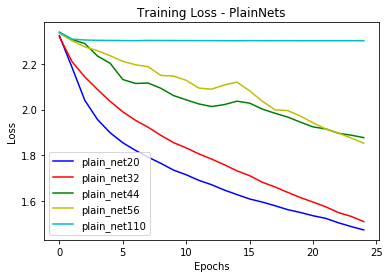

In [6]:
import matplotlib.pyplot as plt

plt.plot(df_model_hist['epochs'], df_model_hist['train_loss_plain_net20'], 'b', label='plain_net20')
plt.plot(df_model_hist['epochs'], df_model_hist['train_loss_plain_net32'], 'r', label='plain_net32')
plt.plot(df_model_hist['epochs'], df_model_hist['train_loss_plain_net44'], 'g', label='plain_net44')
plt.plot(df_model_hist['epochs'], df_model_hist['train_loss_plain_net56'], 'y', label='plain_net56')
plt.plot(df_model_hist['epochs'], df_model_hist['train_loss_plain_net110'], 'c', label='plain_net110')


plt.title('Training Loss - PlainNets')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

It can be seen that the model loss increases as the depth of the model increases. Below plot verifies the same using validation loss.

In [ ]:
plt.plot(df_losses['epochs'], df_losses['val_loss_plain_net20'], 'b', label='plain_net20')
plt.plot(df_losses['epochs'], df_losses['val_loss_plain_net32'], 'r', label='plain_net32')
plt.plot(df_losses['epochs'], df_losses['val_loss_plain_net44'], 'g', label='plain_net44')
plt.plot(df_losses['epochs'], df_losses['val_loss_plain_net56'], 'y', label='plain_net56')
plt.plot(df_losses['epochs'], df_losses['val_loss_plain_net110'], 'c', label='plain_net110')

plt.title('Validation Loss - PlainNets')
plt.xlabel('Epochs')

plt.ylabel('Loss')
plt.legend()

plt.show()

Also as expected, the accuracy keeps decreasing as the model depth increases for these plain Nets.

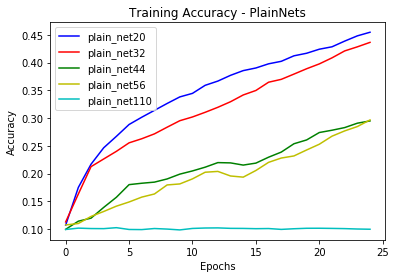

In [7]:
import matplotlib.pyplot as plt

plt.plot(df_losses['epochs'], df_losses['train_acc_plain_net20'], 'b', label='plain_net20')
plt.plot(df_losses['epochs'], df_losses['train_acc_plain_net32'], 'r', label='plain_net32')
plt.plot(df_losses['epochs'], df_losses['train_acc_plain_net44'], 'g', label='plain_net44')
plt.plot(df_losses['epochs'], df_losses['train_acc_plain_net56'], 'y', label='plain_net56')
plt.plot(df_losses['epochs'], df_losses['train_acc_plain_net110'], 'c', label='plain_net110')


plt.title('Training Accuracy - PlainNets')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

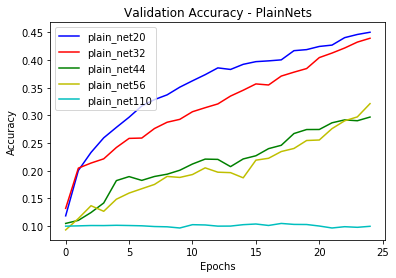

In [9]:
plt.plot(df_losses['epochs'], df_losses['val_acc_plain_net20'], 'b', label='plain_net20')
plt.plot(df_losses['epochs'], df_losses['val_acc_plain_net32'], 'r', label='plain_net32')
plt.plot(df_losses['epochs'], df_losses['val_acc_plain_net44'], 'g', label='plain_net44')
plt.plot(df_losses['epochs'], df_losses['val_acc_plain_net56'], 'y', label='plain_net56')
plt.plot(df_losses['epochs'], df_losses['val_acc_plain_net110'], 'c', label='plain_net110')

plt.title('Validation Accuracy - PlainNets')
plt.xlabel('Epochs')

plt.ylabel('Accuracy')
plt.legend()

plt.show()

# RESNET Plots

Now let us see the results for Residual Networks

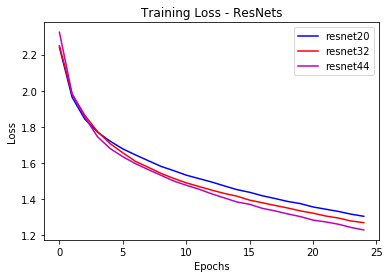

In [198]:
plt.plot(df_losses['epochs'], df_losses['train_loss_resnet20'], 'b', label='resnet20')
plt.plot(df_losses['epochs'], df_losses['train_loss_resnet32'], 'r', label='resnet32')
plt.plot(df_losses['epochs'], df_losses['train_loss_resnet38'], 'm', label='resnet44')
#plt.plot(df_losses['epochs'], df_losses['train_loss_resnet44'], 'g', label='resnet44')
#plt.plot(df_losses['epochs'], df_losses['train_loss_resnet50'], 'm', label='resnet50')
#plt.plot(df_losses['epochs'], df_losses['train_loss_resnet56'], 'y', label='resnet56')
#plt.plot(df_losses['epochs'], df_losses['train_loss_resnet110'], 'c', label='resnet110')
#plt.plot(df_losses['epochs'], df_losses['train_loss_resnet812'], 'm', label='resnet812')


plt.title('Training Loss - ResNets')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
plt.plot(df_losses['epochs'], df_losses['val_loss_resnet20'], 'b', label='resnet20')
plt.plot(df_losses['epochs'], df_losses['val_loss_resnet32'], 'r', label='resnet32')
plt.plot(df_losses['epochs'], df_losses['val_loss_resnet44'], 'g', label='resnet44')
#plt.plot(df_losses['epochs'], df_losses['val_loss_resne50'], 'm', label='resnet50')
#plt.plot(df_losses['epochs'], df_losses['val_loss_resnet56'], 'y', label='resnet56')
#plt.plot(df_losses['epochs'], df_losses['train_loss_resnet110'], 'c', label='resnet110')
#plt.plot(df_losses['epochs'], df_losses['train_loss_resnet812'], 'm', label='resnet812')


plt.title('Validation Loss - ResNets')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

As can be seen from these plots, contrary to plain networks, the loss( training loss as well as validation loss) decreases with increase in the depth of the network. And as is shown by the below two plots, the accuracy increases with increase in the depth of the network.

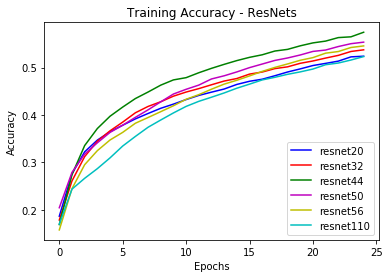

In [150]:
plt.plot(df_losses['epochs'], df_losses['train_acc_resnet20'], 'b', label='resnet20')
plt.plot(df_losses['epochs'], df_losses['train_acc_resnet32'], 'r', label='resnet32')
plt.plot(df_losses['epochs'], df_losses['train_acc_resnet44'], 'g', label='resnet44')
plt.plot(df_losses['epochs'], df_losses['train_acc_resnet50'], 'm', label='resnet50')
plt.plot(df_losses['epochs'], df_losses['train_acc_resnet56'], 'y', label='resnet56')
plt.plot(df_losses['epochs'], df_losses['train_acc_resnet110'], 'c', label='resnet110')


plt.title('Training Accuracy - ResNets')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

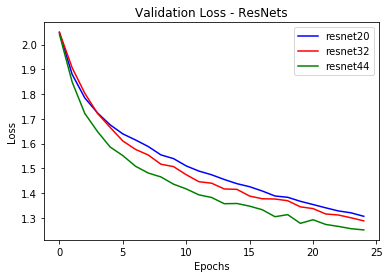

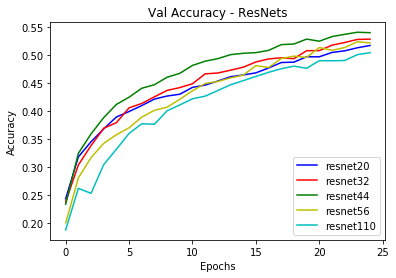

In [140]:
plt.plot(df_losses['epochs'], df_losses['val_acc_resnet20'], 'b', label='resnet20')
plt.plot(df_losses['epochs'], df_losses['val_acc_resnet32'], 'r', label='resnet32')
plt.plot(df_losses['epochs'], df_losses['val_acc_resnet44'], 'g', label='resnet44')
plt.plot(df_losses['epochs'], df_losses['val_acc_resnet50'], 'm', label='resnet50')
plt.plot(df_losses['epochs'], df_losses['val_acc_resnet56'], 'y', label='resnet56')
plt.plot(df_losses['epochs'], df_losses['val_acc_resnet110'], 'c', label='resnet110')


plt.title('Val Accuracy - ResNets')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Model Comparison

Now let us compare the accuracy of different models. I have fitted a VGG16() model as well. As can be seen that the residual network performs much better than the other two networks.

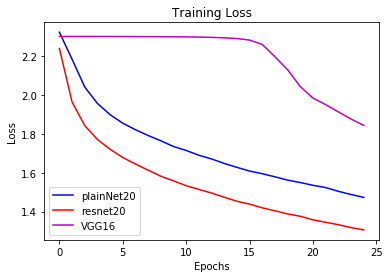

In [172]:
plt.plot(df_losses['epochs'], df_losses['train_loss_plain_net20'], 'b', label='plainNet20')
plt.plot(df_losses['epochs'], df_losses['train_loss_resnet20'], 'r', label='resnet20')
plt.plot(df_losses['epochs'], df_losses['train_loss_VGG16'], 'm', label='VGG16')

plt.title('Models Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

ALl these results are saved in the below csv

In [233]:
df_losses.to_csv("/home/xena/Desktop/manoranjan/model_losses_imagenet.csv")

# ResNet Accuracy test

I have run the resnet44 model for very high epochs and below graphs shows the increased accuracy and decreased losses. It also shows the saturation of these models on validation data for higgher epochs.

In [199]:
resnet44_data = pd.DataFrame(columns=['epochs',
                                  'train_loss_resnet44',
                                  'val_loss_resnet44',
                                  'train_acc_resnet44',
                                  'val_acc_resnet44'])
resnet44_data['epochs'] = np.arange(epochs)
history_dict = history.history
resnet44_data['train_loss_resnet44'] = history_dict['loss']
resnet44_data['val_loss_resnet44'] = history_dict['val_loss']
resnet44_data['train_acc_resnet44'] = history_dict['acc']
resnet44_data['val_acc_resnet44'] = history_dict['val_acc']

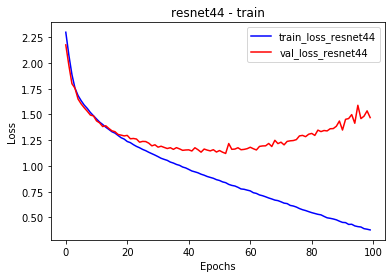

In [200]:
plt.plot(resnet44_data['epochs'], resnet44_data['train_loss_resnet44'], 'b', label='train_loss_resnet44')
plt.plot(resnet44_data['epochs'], resnet44_data['val_loss_resnet44'], 'r', label='val_loss_resnet44')

plt.title('resnet44 - train')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

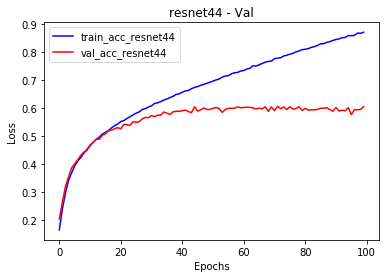

In [201]:
plt.plot(resnet44_data['epochs'], resnet44_data['train_acc_resnet44'], 'b', label='train_acc_resnet44')
plt.plot(resnet44_data['epochs'], resnet44_data['val_acc_resnet44'], 'r', label='val_acc_resnet44')

plt.title('resnet44 - Val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [232]:
resnet44_data.to_csv("/home/xena/Desktop/manoranjan/resnet44_data.csv")